In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.datasets import Datasets, MapDataset
from gammapy.data import Observation, observatory_locations
from regions import CircleSkyRegion
from scipy.stats import chi2, norm

import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit
from gammapy.catalog import CATALOG_REGISTRY, SourceCatalogHGPS

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	version                : 0.20.1     
	path                   : D:\Documents\Miniconda\envs\gammapy-0.20.1\lib\site-packages\gammapy 



In [4]:
print(CATALOG_REGISTRY)
catalog=SourceCatalogHGPS()
source = catalog[3]

model = source.sky_model()
print(model)

Registry
--------

SourceCatalogGammaCat: gamma-cat 
SourceCatalogHGPS    : hgps 
SourceCatalog2HWC    : 2hwc 
SourceCatalog3FGL    : 3fgl 
SourceCatalog4FGL    : 4fgl 
SourceCatalog2FHL    : 2fhl 
SourceCatalog3FHL    : 3fhl 
SourceCatalog3HWC    : 3hwc 

SkyModel

  Name                      : HESS J1018-589 B
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.196   +/-    0.09             
    amplitude                     :   9.15e-14   +/- 1.1e-14 1 / (cm2 s TeV)
    reference             (frozen):      2.742       TeV         
    lon_0                         :    284.223   +/-    0.04 deg         
    lat_0                         :     -1.772   +/-    0.03 deg         
    sigma                         :      0.150   +/-    0.03 deg         
    e                     (frozen):      0.000                  

In [5]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 6.0*u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [7]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [8]:
# Create an in-memory observation
location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing, livetime=livetime, irfs=irfs, location=location
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.25
	duration          : 21600.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [9]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

In [10]:
bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
#bkg_model.spectral_model.norm.value = np.random.normal(1,0.1)
#bkg_model.spectral_model.tilt.value = np.random.normal(0,0.05)
spectral_model=PowerLawSpectralModel(
    amplitude="1e-12 cm-2 s-1 TeV-1", index=2, reference="1 TeV"
)
spatial_model=GaussianSpatialModel(
    lon_0="0.4 deg", lat_0="-0.6 deg", sigma="0.1 deg", frame="galactic"  
)
spatial_model.lon_0.min = spatial_model.lon_0.value - 0.5
spatial_model.lon_0.max = spatial_model.lon_0.value + 0.5
spatial_model.lat_0.min = spatial_model.lat_0.value - 0.5
spatial_model.lat_0.max = spatial_model.lat_0.value + 0.5

model = SkyModel(spectral_model, spatial_model)
Models([bkg_model, model]).parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,int32,float64,float64,bool,bool,str1
spectral,norm,1.0000e+00,,0.000e+00,nan,nan,False,True,
spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,index,2.0000e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spatial,lon_0,4.0000e-01,deg,0.000e+00,-1.000e-01,9.000e-01,False,False,
spatial,lat_0,-6.0000e-01,deg,0.000e+00,-1.100e+00,-1.000e-01,False,False,
spatial,sigma,1.0000e-01,deg,0.000e+00,0.000e+00,nan,False,False,


In [11]:
dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)

dataset.models =  Models([bkg_model, model])
dataset.fake()
# -- like an observation
dataset.models =  Models([bkg_model])    
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=dataset)
L0 = result.total_stat
print(L0)

dataset.models = Models([bkg_model, model])
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=dataset)
L1 = result.total_stat
print(L1)
TS=L0-L1

613995.0064651846
613103.1753662747


In [12]:
TS

891.8310989099555

In [13]:
result.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,norm,1.0002e+00,,1.443e-03,nan,nan,False,True,
spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,index,2.0049e+00,,4.542e-02,nan,nan,False,False,
spectral,amplitude,1.0563e-12,cm-2 s-1 TeV-1,6.193e-14,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spatial,lon_0,4.0156e-01,deg,6.822e-03,-1.000e-01,9.000e-01,False,False,
spatial,lat_0,-6.0622e-01,deg,6.801e-03,-1.100e+00,-1.000e-01,False,False,
spatial,sigma,1.0731e-01,deg,4.652e-03,0.000e+00,nan,False,False,


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

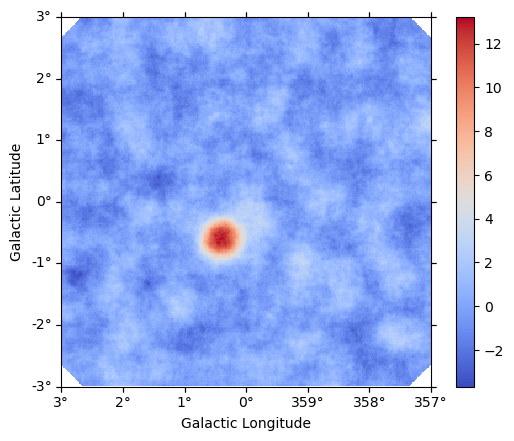

In [14]:
dataset2 = dataset.copy()
dataset2.models = None
from gammapy.estimators import *
est = ExcessMapEstimator(correlation_radius=0.3*u.deg)
res = est.run(dataset2)
res["sqrt_ts"].plot(add_cbar=True, cmap="coolwarm")

In [15]:
dataset

In [16]:
def sigma_to_ts(sigma, df=1):
    """Convert sigma to delta ts"""
    p_value = 2 * norm.sf(sigma)
    return chi2.isf(p_value, df=df)

def ts_to_sigma(ts, df=1):
    """Convert delta ts to sigma"""
    p_value = chi2.sf(ts, df=df)
    return norm.isf(0.5 * p_value)

sigma=ts_to_sigma(TS,6)
print(sigma)

29.35294230220207
